In [206]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [207]:
!wget -O female.csv https://api.dane.gov.pl/resources/54110,lista-imion-zenskich-w-rejestrze-pesel-stan-na-19012024-imie-pierwsze/csv
!wget -O male.csv https://api.dane.gov.pl/resources/54109,lista-imion-meskich-w-rejestrze-pesel-stan-na-19012023-imie-pierwsze/csv


--2024-04-03 13:38:46--  https://api.dane.gov.pl/resources/54110,lista-imion-zenskich-w-rejestrze-pesel-stan-na-19012024-imie-pierwsze/csv
Resolving api.dane.gov.pl (api.dane.gov.pl)... 185.41.93.178
Connecting to api.dane.gov.pl (api.dane.gov.pl)|185.41.93.178|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://api.dane.gov.pl/media/resources/20240126/8_-_Wykaz_imion_%C5%BCe%C5%84skich_os%C3%B3b_%C5%BCyj%C4%85cych_wg_pola_imi%C4%99_pierwsze_wyst%C4%99puj%C4%85cych_w_rejestrze_PESEL_bez_zgon%C3%B3w.csv [following]
--2024-04-03 13:38:47--  https://api.dane.gov.pl/media/resources/20240126/8_-_Wykaz_imion_%C5%BCe%C5%84skich_os%C3%B3b_%C5%BCyj%C4%85cych_wg_pola_imi%C4%99_pierwsze_wyst%C4%99puj%C4%85cych_w_rejestrze_PESEL_bez_zgon%C3%B3w.csv
Reusing existing connection to api.dane.gov.pl:443.
HTTP request sent, awaiting response... 200 OK
Length: 469975 (459K) [application/octet-stream]
Saving to: ‘female.csv’

female.csv          100%[===================>

In [208]:
def filter_names_by_threshold(filename, threshold):
    names = []
    with open(filename, 'r', encoding='utf8') as file:
        lines = file.read().splitlines()
        for line in lines[1:]:
            entry = line.split(",")
            if int(entry[2]) > threshold:
                names.append(entry[0])
    return names



femaleNames = filter_names_by_threshold('female.csv', 20)
print("Female names number with a number greater than 100: " + str(len(femaleNames)))
print(femaleNames[:8])

maleNames = filter_names_by_threshold('male.csv', 20)
print("Male names number with a number greater than 100: " + str(len(maleNames)))
print(maleNames[:8])

Female names number with a number greater than 100: 3708
['ANNA', 'KATARZYNA', 'MARIA', 'MAŁGORZATA', 'AGNIESZKA', 'BARBARA', 'EWA', 'MAGDALENA']
Male names number with a number greater than 100: 5269
['PIOTR', 'KRZYSZTOF', 'TOMASZ', 'ANDRZEJ', 'PAWEŁ', 'MICHAŁ', 'JAN', 'MARCIN']


In [209]:
file2 = open('male.csv', 'r',encoding='utf8').read().splitlines()
maleNames=file2[1:]
maleNames=[entry.split(",")[0] for entry in maleNames]
print("Male names number: "+str(len(maleNames)))
maleNames[:8]

Male names number: 37053


['PIOTR', 'KRZYSZTOF', 'TOMASZ', 'ANDRZEJ', 'PAWEŁ', 'MICHAŁ', 'JAN', 'MARCIN']

In [210]:
def has_polish_or_english_chars(name):
    polish_chars = 'ĄĆĘŁŃÓŚŹŻABCDEFGHIJKLMNOPQRSTUVWXYZ'
    return all(char in polish_chars for char in name)

#source=femaleNames+maleNames
source=femaleNames
print("Combined names number: "+str(len(source)))
#Lets filter out names with spaces because those can be aproximated as 2 names

words= list(filter(lambda x: ' ' not in x, source))
print("Filtered names number: "+str(len(words)))
words= list(filter(lambda x: has_polish_or_english_chars(x), words))
print("Filtered names number: "+str(len(words)))
random.shuffle(words)

words[:10]
#wierdNames=list(filter(lambda x: ' ' in x, source))
#wierdNames[:8]

Combined names number: 3708
Filtered names number: 3646
Filtered names number: 3517


['AUGUSTYNA',
 'KAMILLA',
 'MELEK',
 'BOHDANNA',
 'ESTER',
 'LUDOMIRA',
 'EMINA',
 'SALOMEA',
 'CASEY',
 'PATRIZIA']

In [211]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
VOCAB_SIZE=len(chars)+1
print(VOCAB_SIZE)

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z', 27: 'Ó', 28: 'Ą', 29: 'Ę', 30: 'Ł', 31: 'Ń', 32: 'Ś', 33: 'Ż', 0: '.'}
34


In [212]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([20319, 3]) torch.Size([20319])
torch.Size([2543, 3]) torch.Size([2543])
torch.Size([2601, 3]) torch.Size([2601])


In [213]:
BATCH_SIZE = 32
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((VOCAB_SIZE, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, VOCAB_SIZE), generator=g)
b2 = torch.randn(VOCAB_SIZE, generator=g)
parameters = [C, W1, b1, W2, b2]

In [214]:
sum(p.nelement() for p in parameters) # number of parameters in total

13374

In [215]:
for p in parameters:
  p.requires_grad = True

In [216]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [217]:
lri = []
lossi = []
stepi = []

In [218]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

  # forward pass
  emb = C[Xtr[ix]] # (BATCH_SIZE2, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (BATCH_SIZE, 100)
  logits = h @ W2 + b2 # (BATCH_SIZE, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

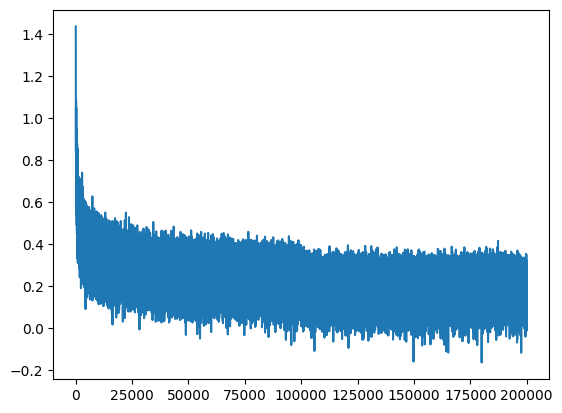

In [219]:
plt.plot(stepi, lossi)

In [220]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.5616, grad_fn=<NllLossBackward0>)

In [221]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4367, grad_fn=<NllLossBackward0>)

In [222]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4437, grad_fn=<NllLossBackward0>)

In [223]:
# sample from the model
g = torch.Generator()#.manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

CYNTHIA.
FLOREN.
PALA.
LUDWA.
YEVHENARA.
MELITASCELICA.
JANA.
LOREN.
ABI.
FLORENTI.
ARLOTTANISŁAWA.
KEDBREN.
EVE.
AMALI.
MEGINA.
INGRID.
VALICA.
ELFIRAPTUNA.
PRAKSUNICA.
AMBRIGITTA.
